# Part 1: User Clustering with Average Ratings

---

## Overview

This notebook implements part 1: user clustering with average ratings.

---

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import sys
import os


# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
sys.path.append("/home/yousef/irs_ass/")
from utils.data_loader import get_user_avg_ratings, get_target_users, get_target_items, get_preprocessed_dataset
from utils.similarity import calculate_user_mean_centered_cosine

---

## Load Data

In [30]:
print("Loading user average ratings...")
df = get_user_avg_ratings()

# 2. Create a 1-dimensional feature vector for each user
X = df[['r_u_bar']].values

# 3. Calculate mean
mu = df['r_u_bar'].mean()
print(f"Mean of users' average ratings (mu): {mu:.4f}")

# 4. Compute Standard Deviation
sigma = df['r_u_bar'].std()
print(f"Standard deviation (sigma): {sigma:.4f}")

# 5. Normalize feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Apply K-means with different K
k_values = [5, 10, 15, 20, 30, 50]
wcss = []
silhouette_scores = []

Loading user average ratings...
Mean of users' average ratings (mu): 3.7392
Standard deviation (sigma): 0.8240


In [31]:
print("\nStarting K-means clustering analysis...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # 7.2 WCSS
    wcss.append(kmeans.inertia_)
    
    # 7.4 Silhouette Score (Sampled for performance)
    # using a large sample of 40,000 to balance accuracy and speed
    #eldata kbera lazem na5od sample 
    if len(X_scaled) > 1000:
        score = silhouette_score(X_scaled, labels, sample_size=1000, random_state=42)
    else:
        score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    
    print(f"  K={k}: WCSS={kmeans.inertia_:.4f}, Silhouette={score:.4f}")


Starting K-means clustering analysis...
  K=5: WCSS=9004.2379, Silhouette=0.6143
  K=10: WCSS=1312.1510, Silhouette=0.7037
  K=15: WCSS=483.0559, Silhouette=0.7045
  K=20: WCSS=222.8547, Silhouette=0.7377
  K=30: WCSS=81.0368, Silhouette=0.7695
  K=50: WCSS=23.5898, Silhouette=0.7871



Plots saved to /home/yousef/irs_ass/results/clustering_metrics.png


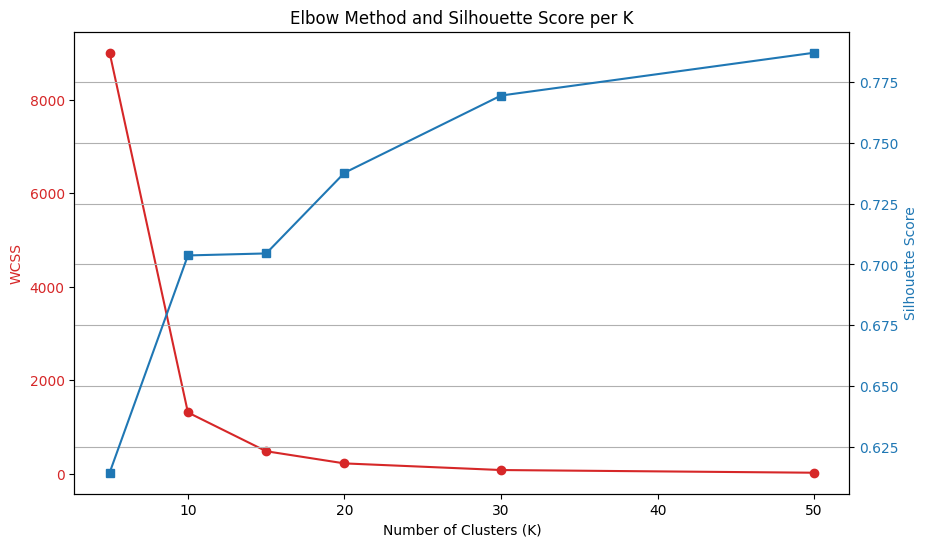

In [32]:
results_dir = os.path.join("/home/yousef/irs_ass/", 'results')
os.makedirs(results_dir, exist_ok=True)

fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(k_values, wcss, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, silhouette_scores, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Elbow Method and Silhouette Score per K')
plt.grid(True)
plot_path = os.path.join(results_dir, 'clustering_metrics.png')
plt.savefig(plot_path)
print(f"\nPlots saved to {plot_path}")

In [33]:
optimal_k_index = np.argmax(silhouette_scores)
optimal_k = 10
print(f"\nOptimal K based on max Silhouette Score: {optimal_k}")
# Rerun for Optimal K
best_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = best_kmeans.fit_predict(X_scaled)
centroids_scaled = best_kmeans.cluster_centers_

# Inverse transform centroids to get original rating scale
centroids_original = scaler.inverse_transform(centroids_scaled).flatten()


Optimal K based on max Silhouette Score: 10


In [34]:
# Rerun for Optimal K
best_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = best_kmeans.fit_predict(X_scaled)
centroids_scaled = best_kmeans.cluster_centers_

# Inverse transform centroids to get original rating scale
centroids_original = scaler.inverse_transform(centroids_scaled).flatten()



User distribution per cluster:
cluster
0    15821
1    15056
2    37275
3     5250
4    21781
5     3515
6     9347
7     3411
8    25094
9    11364
Name: count, dtype: int64
Distribution plot saved to /home/yousef/irs_ass/results/user_distribution_k10.png


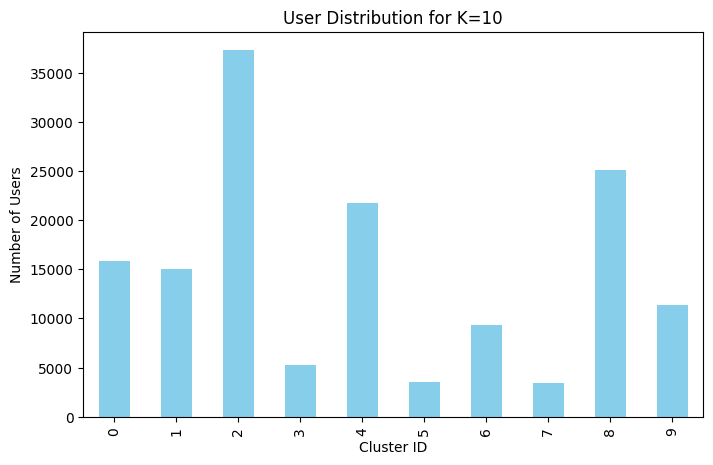

In [35]:
# 8.1 Distribution of users
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nUser distribution per cluster:")
print(cluster_counts)

# Bar chart for distribution
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title(f'User Distribution for K={optimal_k}')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Users')
dist_plot_path = os.path.join(results_dir, f'user_distribution_k{optimal_k}.png')
plt.savefig(dist_plot_path)
print(f"Distribution plot saved to {dist_plot_path}")

In [36]:
# 8.2 & 8.3 Analyze Centroids
print("\nCluster Centroids (Average Ratings) and Interpretation:")
cluster_info = []
for cluster_id in range(optimal_k):
    rating = centroids_original[cluster_id]
    # Determine strict or generous relative to global mean
    nature = "Generous" if rating > mu else "Strict"
    cluster_info.append({
        'Cluster': cluster_id,
        'Avg Rating': rating,
        'Nature': nature,
        'Count': cluster_counts[cluster_id]
    })

info_df = pd.DataFrame(cluster_info).sort_values(by='Avg Rating')
print(info_df.to_string(index=False))
print("\nAnalysis completed.")


Cluster Centroids (Average Ratings) and Interpretation:
 Cluster  Avg Rating   Nature  Count
       3    1.035692   Strict   5250
       5    1.995352   Strict   3515
       7    2.553834   Strict   3411
       1    3.027666   Strict  15056
       4    3.435388   Strict  21781
       8    3.722274   Strict  25094
       2    3.990754 Generous  37275
       9    4.243859 Generous  11364
       6    4.541493 Generous   9347
       0    4.990863 Generous  15821

Analysis completed.


In [38]:
def get_user_item_ratings(df):
    """
    Converts dataframe to dictionary of {user_id: {item_id: rating}}
    """
    user_item_ratings = {}
    for _, row in df.iterrows():
        user_id = int(row['user'])
        item_id = int(row['item'])
        rating = float(row['rating'])
        
        if user_id not in user_item_ratings:
            user_item_ratings[user_id] = {}
        user_item_ratings[user_id][item_id] = rating
    return user_item_ratings

In [39]:
print("\n" + "="*50)
print("Starting Clustering-Based CF (using Optimal K=50)")
print("="*50)
# 1. Load Data
print("Loading full dataset for CF...")
full_df = get_preprocessed_dataset()
user_item_ratings = get_user_item_ratings(full_df)
target_users = get_target_users()
target_items = get_target_items()

# Pre-compute user means for similarity calculation
user_means = df.set_index('user')['r_u_bar'].to_dict()

# 2. Assign Users to Clusters
# We already have 'cluster' column in `df` from the best_kmeans (K=50)
user_cluster_map = df.set_index('user')['cluster'].to_dict()

# Group users by cluster for fast retrieval
cluster_users = {}
for user, cluster in user_cluster_map.items():
    if cluster not in cluster_users:
        cluster_users[cluster] = []
    cluster_users[cluster].append(user)
# 3. Prediction Loop
print("\nPredicting ratings for Target Users...")

total_users_N = len(df)
total_similarity_computations_clustering = 0


Starting Clustering-Based CF (using Optimal K=50)
Loading full dataset for CF...

Predicting ratings for Target Users...


In [40]:

for u_id in target_users:
    if u_id not in user_cluster_map:
        print(f"Target User {u_id} not found in clusters (maybe filtered out?). Skipping.")
        continue
        
    u_cluster = user_cluster_map[u_id]
    neighbors_in_cluster = cluster_users[u_cluster]
    
    # Filter out the user themselves
    neighbors_in_cluster = [n for n in neighbors_in_cluster if n != u_id]
    
    cluster_size = len(neighbors_in_cluster)
    total_similarity_computations_clustering += cluster_size
    
    print(f"\nTarget User: {u_id} | Cluster: {u_cluster} | Potential Neighbors: {cluster_size}")
    
    # Compute Similarity with users in the SAME cluster only
    similarities = []
    u_ratings = user_item_ratings.get(u_id, {})
    u_mean = user_means.get(u_id, 3.0)
    
    for v_id in neighbors_in_cluster:
        v_ratings = user_item_ratings.get(v_id, {})
        v_mean = user_means.get(v_id, 3.0)
        
        sim = calculate_user_mean_centered_cosine(u_ratings, v_ratings, u_mean, v_mean)
        if sim > 0: # Only consider positive correlation for neighbors usually, or all non-zero? Standard is often positive.
            similarities.append((v_id, sim))
    
    # Sort and Select Top 20%
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_k_count = max(1, int(len(similarities) * 0.20))
    top_neighbors = similarities[:top_k_count]
    
    print(f"  Valid Neighbors (Sim > 0): {len(similarities)}")
    print(f"  Selected Top 20% Neighbors: {len(top_neighbors)}")
    if top_neighbors:
         print(f"  Top Neighbor ID: {top_neighbors[0][0]}, Sim: {top_neighbors[0][1]:.4f}")
    # Predict for Target Items
    for i_id in target_items:
        # Weighted Average Prediction
        numerator = 0.0
        denominator = 0.0
        
        for v_id, sim in top_neighbors:
            v_ratings = user_item_ratings.get(v_id, {})
            if i_id in v_ratings:
                r_vi = v_ratings[i_id]
                v_mean = user_means.get(v_id, 3.0)
                numerator += sim * (r_vi - v_mean)
                denominator += sim
        
        if denominator > 0:
            prediction = u_mean + (numerator / denominator)
        else:
            prediction = u_mean # Default to user mean if no neighbors rated item
        
        # Clip prediction to valid range if needed (1-5)
        prediction = max(1.0, min(5.0, prediction))
        
        print(f"  -> Prediction for Item {i_id}: {prediction:.4f}")


Target User: 134471 | Cluster: 4 | Potential Neighbors: 21780
  Valid Neighbors (Sim > 0): 1021
  Selected Top 20% Neighbors: 204
  Top Neighbor ID: 132020, Sim: 0.5634
  -> Prediction for Item 1333: 3.6036
  -> Prediction for Item 1162: 3.3127

Target User: 27768 | Cluster: 4 | Potential Neighbors: 21780
  Valid Neighbors (Sim > 0): 6986
  Selected Top 20% Neighbors: 1397
  Top Neighbor ID: 118401, Sim: 0.1971
  -> Prediction for Item 1333: 3.2915
  -> Prediction for Item 1162: 3.2382

Target User: 16157 | Cluster: 1 | Potential Neighbors: 15055
  Valid Neighbors (Sim > 0): 2410
  Selected Top 20% Neighbors: 482
  Top Neighbor ID: 17425, Sim: 0.1236
  -> Prediction for Item 1333: 3.1590
  -> Prediction for Item 1162: 3.0958


In [ ]:
print("\n" + "="*50)
print("Efficiency Analysis")
print("="*50)

num_target_users = len(target_users)

# computations without clustering = Target Users * (Total Users - 1)
comps_no_clustering = num_target_users * (total_users_N - 1)

# computations with clustering = Sum of (Cluster Size - 1) for each target user
comps_with_clustering = total_similarity_computations_clustering

speedup = comps_no_clustering / comps_with_clustering if comps_with_clustering > 0 else 0
percent_reduction = (1 - (comps_with_clustering / comps_no_clustering)) * 100 if comps_no_clustering > 0 else 0

print(f"Total Users: {total_users_N}")
print(f"Target Users: {num_target_users}")
print(f"Computations (No Clustering): {comps_no_clustering:,}")
print(f"Computations (With Clustering): {comps_with_clustering:,}")
print(f"Speedup Factor: {speedup:.2f}x")
print(f"Efficiency Gain: {percent_reduction:.2f}%")
print("\nAnalysis completed.")